## Introduction

This code get a user's posts and then plot some metrics and statistics to understand how large is her audience and how successful are her posts.

It uses the 'facebook-sdk' module which is a python wrapper for the Facebook Graph API.

## Get all posts

In [342]:
%matplotlib inline

In [341]:
import facebook # install it with 'pip install facebook-sdk'

# Get temporal token from here: https://developers.facebook.com/tools/explorer/
token = "CAACEdEose0cBANsUos0BgOjLPT0NDsDsCtvgaysZC029mWgBJEf1Lu4b3MNLLKaNJJCaiHlOvZAX7C8LOPGzcHAVB4Kg1J4RrYhHZALhtE2qNoimF7ZBLDNNtevbIWk3NJbrw2ZBJ0IlpXrKVPRju7Ybp8ovfOf2T2r2t1zZC49DvI1ewsh2fIkQkrmnRZCYWZCOkUx8FGGEXQZDZD"

graph = facebook.GraphAPI(token)
profile = graph.get_object("me")

In [4]:
profile["name"]

u'Alberto Lumbreras'

In [5]:
def process(container, post):

    if post.has_key('message'):
        message = post['message']
    else:
        message = None

    likes = []
    if post.has_key('likes'):    
        for like in post['likes']['data']:
            likes.append(like['name'])        

    container.append({'message': message,
              'created_time': post['created_time'],
              'likes': likes})
    
    return container

In [6]:
import requests

total_posts = []
container = []
posts = graph.get_connections(profile['id'], 'posts')

total_posts.extend(posts['data'])
count = 0
while count<130:
    if count%10==0: 
        print count
    
    if posts.has_key('data'):
        total_posts.extend(posts['data'])
    else:
        break
    
    try:
        
        total_posts.extend(posts['data'])
        for post in posts['data']:
            container = process(container, post=post)
            
        # Attempt to make a request to the next page of data, if it exists.
        posts = requests.get(posts['paging']['next']).json()    
        count+=1
        
    except KeyError as e:
        # When there are no more pages (['paging']['next']), break from the
        # loop and end the script.
        print "KeyError", e
        break

In [7]:
# Store posts in file for further experiments
import json

user = profile["name"]
fname = user + ".txt"
f = open(fname, 'w')
json.dump(total_posts, f)
f.close()

## Posts, readers and likes

Some terminology:
    
* **Posts**: number of posts
* **Likes**: number of likes
* **Readers**: number of (different) users who liked a post

Every day, we will compute the total number of posts, likes and readers *during the previous 30 days*. We will be specially interested in the number of readers. We would like, in a given 30 days window, to have lots of different readers. 

The idea is to imagine that people who read our posts are those who liked at least one post during the last month. Thus, the number of readers is a rough estimation of the number of people that is (silently or not) reading our posts.

In [8]:
len(container)

3180

In [344]:
# Sometimes we have to drop the last posts in the list. Otherwise it will complain later. I still don't know why.
# uncomment this line and decrease the number until it works

# container = container[0:2800]

In [10]:
from datetime import datetime

likes_dates = []
for d in container:
    if len(d['likes'])==0:
        likes_dates.append((None, 
                            int(datetime.strptime(d['created_time'], '%Y-%m-%dT%H:%M:%S+%f').strftime('%s'))
                           ))       
    for like in d['likes']:
        likes_dates.append((like, 
                            int(datetime.strptime(d['created_time'], '%Y-%m-%dT%H:%M:%S+%f').strftime('%s'))
                           ))

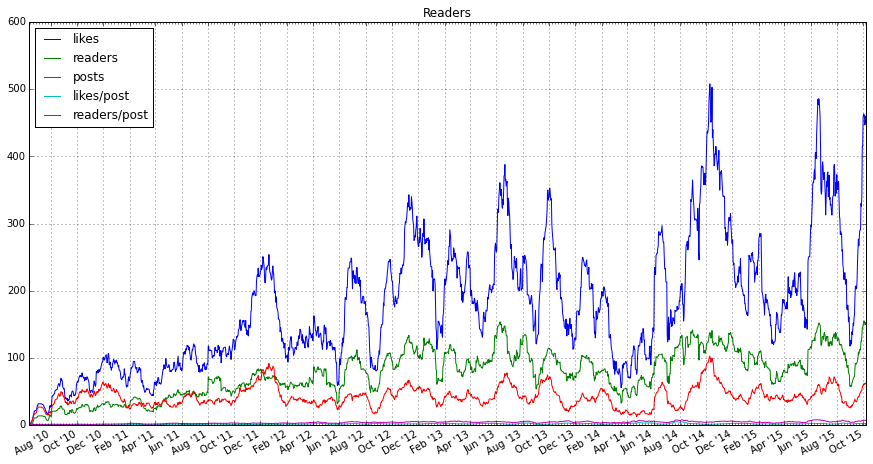

In [74]:
# Compute cumsum (temporal window)
from sets import Set
import numpy as np

NMONTHS = 1

dates = np.array([ld[1] for ld in likes_dates])
steps = np.arange(min(dates),max(dates),3600*24)

window = 3600*24*30*NMONTHS
cumsum_likes = []
cumsum_users = []
cumsum_posts = []
for i in steps:
    mask = (dates < i) & (dates > i - window)
    nlikes = sum(mask)
    nposts = len(set(dates[mask])) # there is a post per timestamp
    nusers = len(set([ld[0] for ld in likes_dates if (ld[1]<i) and (ld[1]>i-window)]))

    cumsum_likes.append(nlikes)
    cumsum_users.append(nusers)
    cumsum_posts.append(nposts)

    
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import dates as da

# every monday
mondays = WeekdayLocator(MONDAY)

# every 3rd month
months = MonthLocator(range(1, 14), bymonthday=1, interval=2)
monthsFmt = DateFormatter("%b '%y")

plt.figure(figsize=(20,10)) 
fig, ax = plt.subplots(figsize=(15,8))
ax.plot_date(da.epoch2num(steps), cumsum_likes, '-', label="likes")
ax.plot_date(da.epoch2num(steps), cumsum_users, '-', label="readers")
ax.plot_date(da.epoch2num(steps), cumsum_posts, '-', label="posts")
ax.plot_date(da.epoch2num(steps), np.array(cumsum_users)/(np.array(cumsum_posts)+0.00001), '-', label="likes/post")
ax.plot_date(da.epoch2num(steps), np.array(cumsum_likes)/(np.array(cumsum_posts)+0.00001), '-', label="readers/post")

ax.legend(loc=2)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(mondays)
ax.autoscale_view()
ax.grid(True)

fig.autofmt_xdate()
plt.title("Readers")
plt.show()

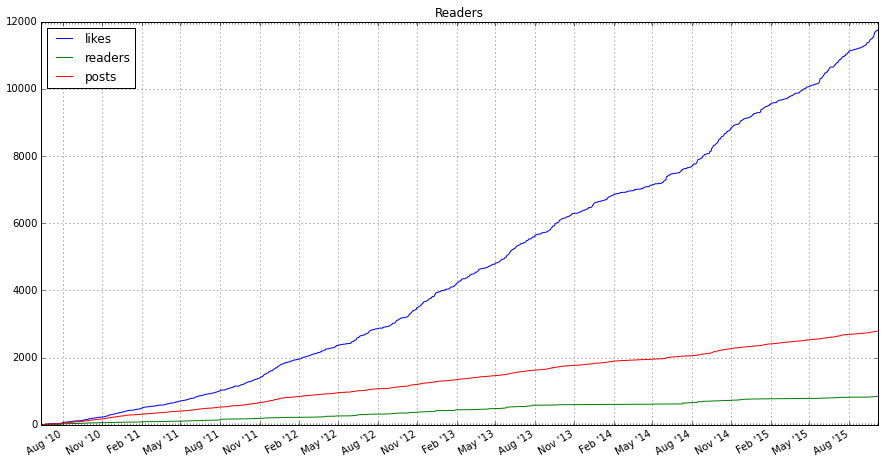

In [13]:
# Compute cumsum (temporal window)
from sets import Set
import numpy as np

NMONTHS = 100

dates = np.array([ld[1] for ld in likes_dates])
steps = np.arange(min(dates),max(dates),3600*24)

window = 3600*24*30*NMONTHS
cumsum_likes = []
cumsum_users = []
cumsum_posts = []
for i in steps:
    
    mask = (dates < i) & (dates > i - window)
    nlikes = sum(mask)
    nposts = len(set(dates[mask])) # there is a post per timestamp
    nusers = len(set([ld[0] for ld in likes_dates if (ld[1]<i) and (ld[1]>i-window)]))

    cumsum_likes.append(nlikes)
    cumsum_users.append(nusers)
    cumsum_posts.append(nposts)
    
    
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import dates as da

# every monday
mondays = WeekdayLocator(MONDAY)

# every 3rd month
months = MonthLocator(range(1, 14), bymonthday=1, interval=3)
monthsFmt = DateFormatter("%b '%y")

plt.figure(figsize=(20,10)) 
fig, ax = plt.subplots(figsize=(15,8))
ax.plot_date(da.epoch2num(steps), cumsum_likes, '-', label="likes")
ax.plot_date(da.epoch2num(steps), cumsum_users, '-', label="readers")
ax.plot_date(da.epoch2num(steps), cumsum_posts, '-', label="posts")

ax.legend(loc=2)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(mondays)
ax.autoscale_view()
ax.grid(True)

fig.autofmt_xdate()
plt.title("Readers")
plt.show()

## Productivity

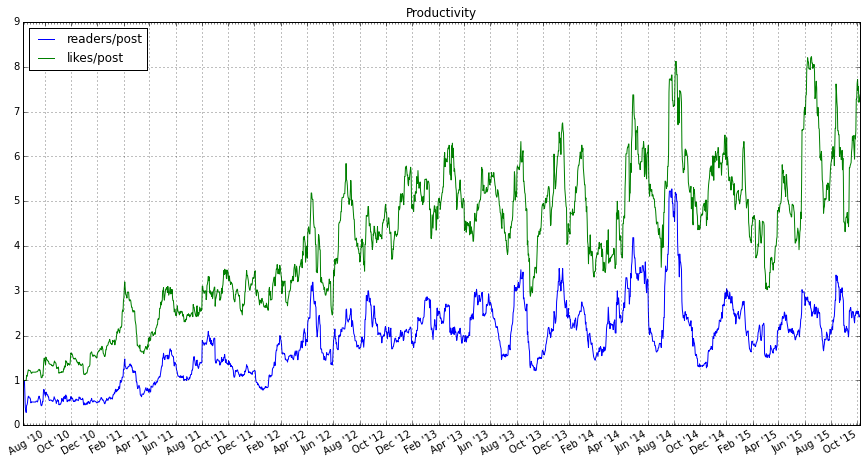

In [12]:
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import MONDAY
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
from matplotlib import dates as da

# every monday
mondays = WeekdayLocator(MONDAY)

# every 3rd month
months = MonthLocator(range(1, 14), bymonthday=1, interval=2)
monthsFmt = DateFormatter("%b '%y")

plt.figure(figsize=(20,10)) 
fig, ax = plt.subplots(figsize=(15,8))
ax.plot_date(da.epoch2num(steps), np.array(cumsum_users)/(np.array(cumsum_posts)+0.00001), '-', label="readers/post")
ax.plot_date(da.epoch2num(steps), np.array(cumsum_likes)/(np.array(cumsum_posts)+0.00001), '-', label="likes/post")

ax.legend(loc=2)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(mondays)
ax.autoscale_view()
ax.grid(True)

fig.autofmt_xdate()
plt.title("Productivity")
plt.show()

## Spectral Analysis of posting activity

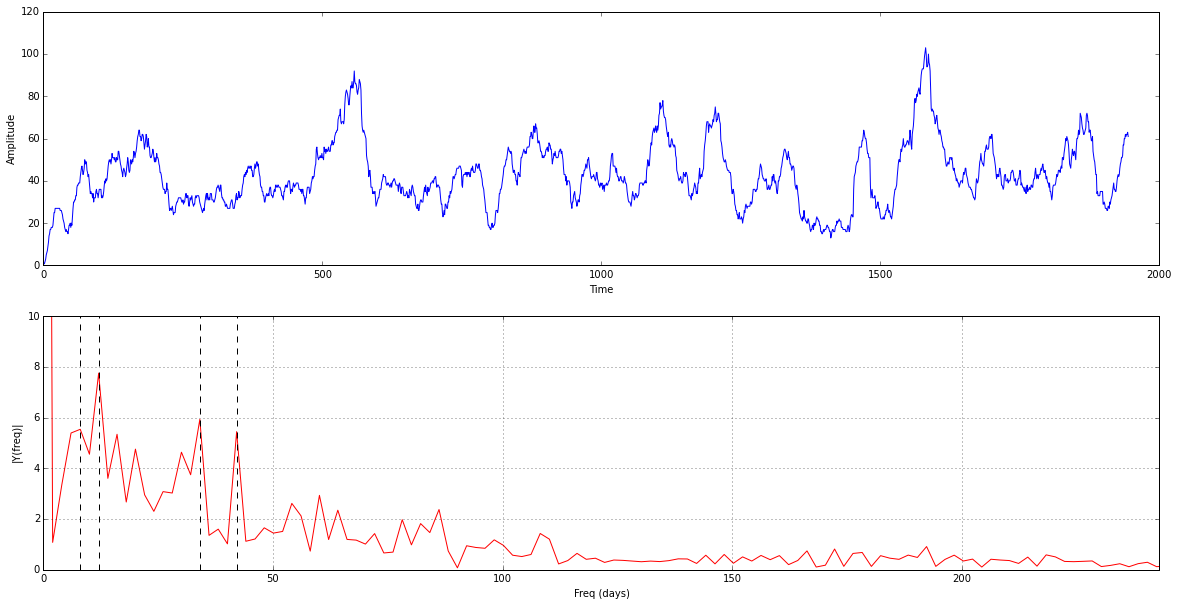

In [338]:
# Spectral analysis of posting activity

from scipy.fftpack import fft
import matplotlib.pyplot as plt

def plot_spectrum(y):
    """Plot the DFT of a discrete signal"""
    N = len(y)
    x = arange(N)

    yf = fft(y)
    yf = 2.0/N * np.abs(yf[0:N/2]) # drop symmetric part and normalize
    xf = np.linspace(0.0, (1.0/2)*(2*N), N/2) # unnormalized frequencies (*2N)
    
    # top frequencies
    topfreqs_idx = np.argsort(np.abs(yf))[::-1]
    topfreqs = xf[topfreqs_idx[0:10]] 
    
    fig, ax = plt.subplots(2, 1, figsize=(20,10))
    
    # plotting the signal in the temporal domain
    ax[0].plot(x, y)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Amplitude')
    
    
    # plotting the signan in the frequency domain (spectrum)
    ax[1].plot(xf, yf,'r') 
    ax[1].set_xlabel('Freq (days)')
    ax[1].set_ylabel('|Y(freq)|')
    ax[1].axvline(topfreqs[1], ls="--", c="k")
    ax[1].axvline(topfreqs[2], ls="--", c="k")
    ax[1].axvline(topfreqs[3], ls="--", c="k")
    ax[1].axvline(topfreqs[4], ls="--", c="k")
    
    plt.ylim(0,10)
    plt.xlim(0,N/2*0.25)
    
    plt.grid()
    plt.show()
    

plot_spectrum(cumsum_posts)